# OpenRocket シミュレーション

In [1]:
import os

import jpype
import numpy as np
from matplotlib import pyplot as plt

import orhelper
from orhelper import FlightDataType, FlightEvent

# Java 17+ ではモジュールシステムにより内部APIへのリフレクションが制限されるため、
# orhelper の startJVM 呼び出しに --add-opens オプションを追加する
_original_startJVM = jpype.startJVM

def _patched_startJVM(*args, **kwargs):
    add_opens = [
        "--add-opens=java.base/java.lang=ALL-UNNAMED",
        "--add-opens=java.base/java.lang.reflect=ALL-UNNAMED",
        "--add-opens=java.base/java.util=ALL-UNNAMED",
    ]
    _original_startJVM(*args, *add_opens, **kwargs)

jpype.startJVM = _patched_startJVM

In [2]:
instance = orhelper.OpenRocketInstance()
instance.__enter__()
orh = orhelper.Helper(instance)

22:24:08.732 [main] INFO  n.s.o.s.providers.TranslatorProvider - Using default locale ja_JP
22:24:08.751 [main] INFO  n.s.o.s.providers.TranslatorProvider - Set up translation for locale ja_JP, debug.currentFile=messages_ja.properties
22:24:08.759 [DatabaseLoadingThread] INFO  n.s.o.d.ComponentPresetDatabaseLoader - Loading component presets from datafiles/presets
22:24:08.762 [DatabaseLoadingThread] INFO  n.s.o.database.MotorDatabaseLoader - Starting reading serialized motor database
22:24:08.763 [DatabaseLoadingThread] DEBUG net.sf.openrocket.util.JarUtil - Found jar file using codeSource
22:24:08.763 [DatabaseLoadingThread] DEBUG net.sf.openrocket.util.JarUtil - Found jar file using codeSource
22:24:08.766 [DatabaseLoadingThread] DEBUG n.s.o.database.MotorDatabaseLoader - Reading motors from file datafiles/thrustcurves/thrustcurves.ser
22:24:08.915 [DatabaseLoadingThread] INFO  n.s.o.database.MotorDatabaseLoader - Ending reading serialized motor database, motorCount=1721
22:24:08.91

In [3]:
# .orkファイルを読み込み、シミュレーションを実行
doc = orh.load_doc('simple.ork')
sim = doc.getSimulation(0)
orh.run_simulation(sim)

data = orh.get_timeseries(sim, [FlightDataType.TYPE_TIME, FlightDataType.TYPE_ALTITUDE, FlightDataType.TYPE_VELOCITY_Z])
events = orh.get_events(sim)

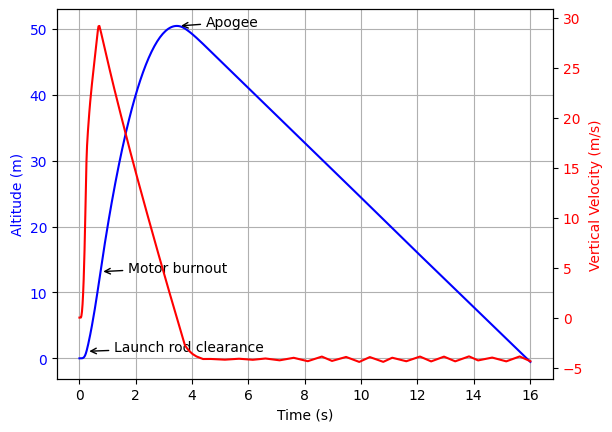

In [4]:
events_to_annotate = {
    FlightEvent.BURNOUT: 'Motor burnout',
    FlightEvent.APOGEE: 'Apogee',
    FlightEvent.LAUNCHROD: 'Launch rod clearance'
}

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()

ax1.plot(data[FlightDataType.TYPE_TIME], data[FlightDataType.TYPE_ALTITUDE], 'b-')
ax2.plot(data[FlightDataType.TYPE_TIME], data[FlightDataType.TYPE_VELOCITY_Z], 'r-')
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Altitude (m)', color='b')
ax2.set_ylabel('Vertical Velocity (m/s)', color='r')
change_color = lambda ax, col: [x.set_color(col) for x in ax.get_yticklabels()]
change_color(ax1, 'b')
change_color(ax2, 'r')

index_at = lambda t: (np.abs(data[FlightDataType.TYPE_TIME] - t)).argmin()
for event, times in events.items():
    if event not in events_to_annotate:
        continue
    for time in times:
        ax1.annotate(events_to_annotate[event], xy=(time, data[FlightDataType.TYPE_ALTITUDE][index_at(time)]),
                     xycoords='data', xytext=(20, 0), textcoords='offset points',
                     arrowprops=dict(arrowstyle="->", connectionstyle="arc3"))

ax1.grid(True)
plt.show()

In [5]:
# JVMをシャットダウン (カーネル再起動前に実行)
instance.__exit__(None, None, None)